In [ ]:
!pip install -U scikit-multiflow

In [2]:
# Required to correctly display interactive (dynamic) plots in Jupyter notebooks.
# This code cell must be run before any other code cell.


# Imports
from skmultiflow.data import FileStream
from skmultiflow.data import SEAGenerator
from skmultiflow.evaluation import EvaluatePrequential
from skmultiflow.bayes import NaiveBayes
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from skmultiflow.drift_detection import ADWIN

from sklearn.linear_model import SGDClassifier

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from importlib import reload
reload(plt)
%matplotlib notebook


# scikit-multiflow demo

---
## 1. Running a classification task

In this example we will use the `SEA` stream generator. A data generator does not store any data, but generates it on demand.

Next we will setup a learning method (model, estimator, algorithm), in this case the Naive Bayes classifier:

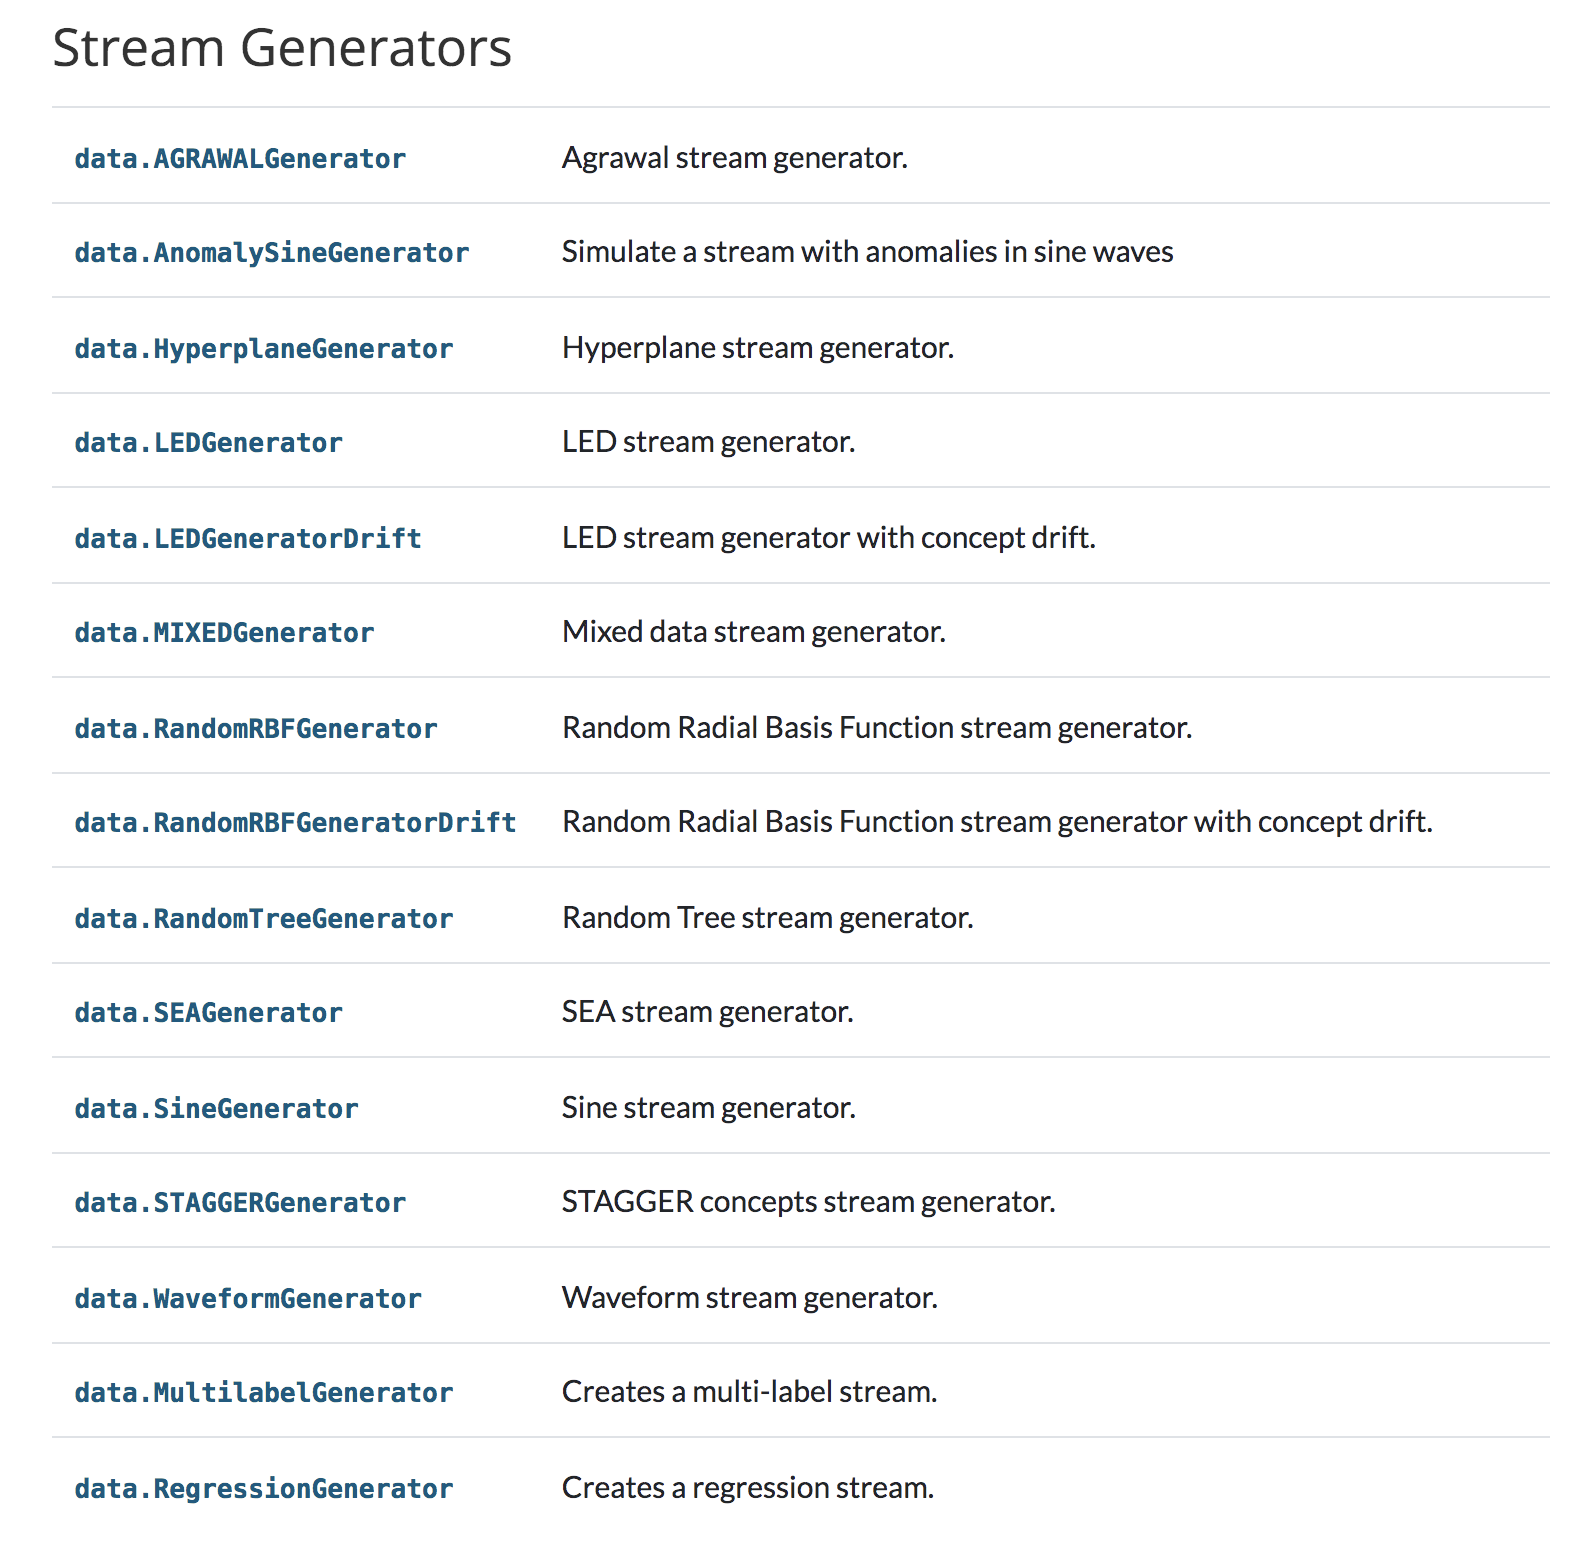

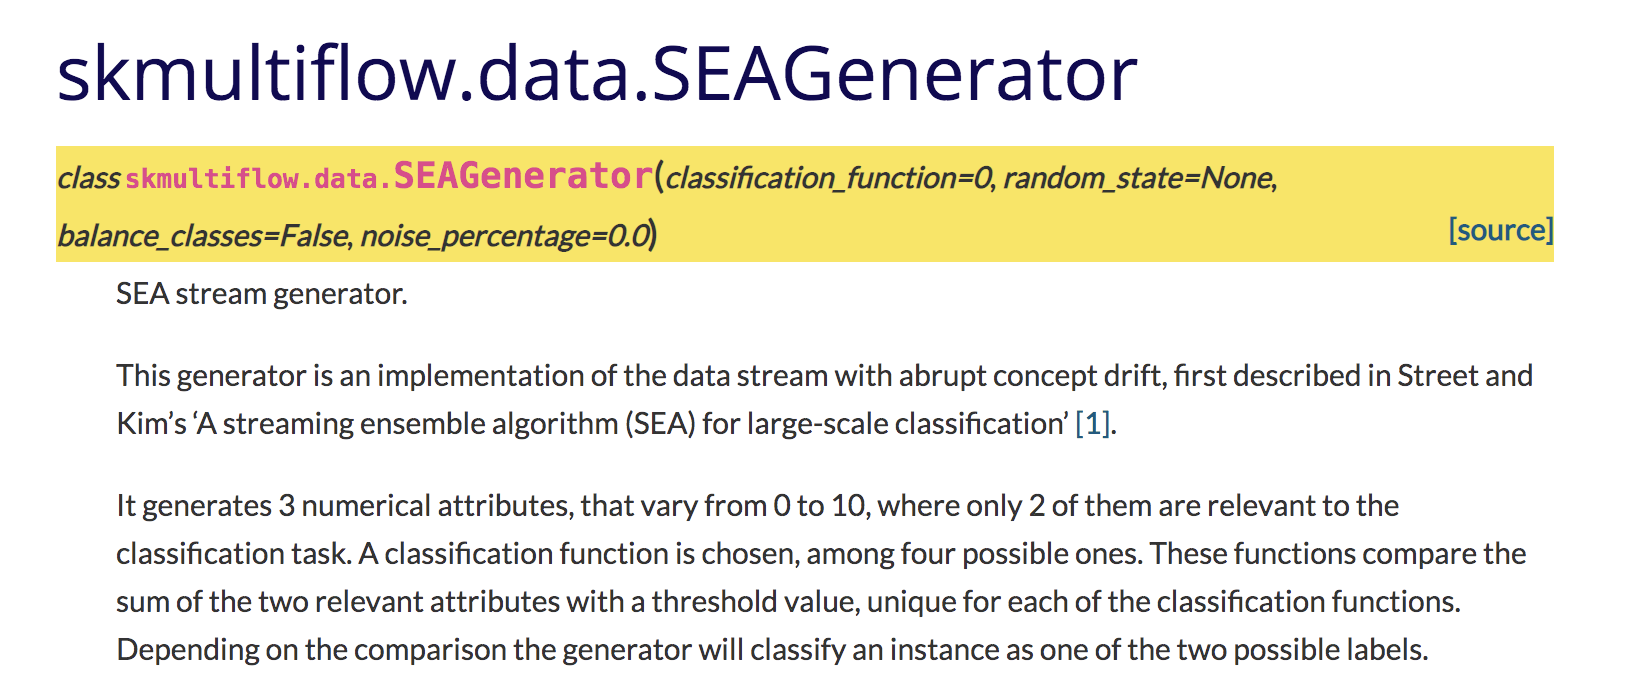

### Prequential evaluation

The prequentail evaluation is easily implemented as a loop:

In [3]:
stream = SEAGenerator(random_state=1)
classifier = NaiveBayes()

In [7]:
# Variables to control evaluation loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 20

# Prequential evaluation loop
while n_samples < max_samples and stream.has_more_samples():
   X, y = stream.next_sample()      # Get one sample from the stream
   print(X," ",y)
   y_pred = classifier.predict(X)   # Predict class for new data
   #print(y_pred)
   if y[0] == y_pred[0]:
       correct_cnt += 1
   classifier.partial_fit(X, y)     # Incrementally train the model with the new data
   n_samples += 1

print('{} samples analyzed.'.format(n_samples))   
print('NaiveBayes classifier accuracy: {}'.format(correct_cnt / n_samples))

[[3.76446324 1.61099437 2.2729794 ]]   [0]
[[0.94554847 1.62921142 8.72213146]]   [0]
[[0.48865276 2.11020106 7.71696201]]   [0]
[[2.97144399 6.72288231 7.64689489]]   [1]
[[1.20224832 3.7435452  9.93083505]]   [0]
[[3.78902635 3.27854541 5.69639136]]   [0]
[[7.35220492 9.31983027 2.35434313]]   [1]
[[0.49671485 8.96862759 0.50230293]]   [1]
[[8.1443058  8.16520472 6.01889563]]   [1]
[[7.91269037 1.4743242  7.92163941]]   [1]
[[1.80358579 4.18287585 4.77837792]]   [0]
[[8.31791999 2.14969584 4.18091157]]   [1]
[[6.0380176  1.70096922 6.16486556]]   [0]
[[7.30126777 7.67636087 7.43983257]]   [1]
[[7.75002797 0.69006816 6.03467773]]   [1]
[[3.85667973 2.46556275 9.52952055]]   [0]
[[1.5663413  7.03917317 3.74754383]]   [1]
[[7.09690497 7.21557896 8.1623398 ]]   [1]
[[1.38925187 1.67140462 0.12185495]]   [0]
[[0.9120619  3.70763861 4.987701  ]]   [0]
20 samples analyzed.
NaiveBayes classifier accuracy: 0.95


**partial_fit**
  - https://scikit-learn.org/0.15/modules/scaling_strategies.html


In this notebook, we show how to easily setup and run experiments in `scikit-multiflow`.

The demo is divided into the follwing parts:

1. Running a classification task 
  1. Prequential evaluation implementation
  2. The `EvaluatePrequential` class

2. Concept drift detection
  1. Drift detection test
  2. Impact on predictive performance
  
---

# **Exercise 1**
1.1 Replace NaiveBayes with whatever you like ML algorithm, and rerun it.

1.2 Replace SEAGenerator with another Stream generator, and rerun it.

---

### `EvaluatePrequential` class

Implements the prequential evaluation method and provides extra functionalities.

Let's run the same experiment on the SEA data but this time we will compare two classifiers:

1. `NaiveBayes`
2. `SGDClassifier`: Linear SVM with SGD training.

We choose the `SGDClassifier` in order to demonstrate the compatibility with incremental methods from `scikit-learn`.

**Note:** `scikit-learn` focuses on the batch learing setting and only a **limited** number of its methods are capable to learn incrementally.

In [10]:
# Setup stream and estimators
stream = SEAGenerator(random_state=1)
nb = NaiveBayes()
svm = SGDClassifier()

# Setup evaluator
eval = EvaluatePrequential(show_plot=True,
                           max_samples=20000,
                           metrics=['accuracy', 'kappa', 'running_time', 'model_size']);
                           #metrics=['accuracy']);

In [11]:

# Run the evaluation
eval.evaluate(stream=stream, model=[nb, svm], model_names=['NB', 'SVM']);

<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [15.18s]
Processed samples: 20000
Mean performance:
NB - Accuracy     : 0.9430
NB - Kappa        : 0.8621
NB - Training time (s)  : 0.77
NB - Testing time  (s)  : 1.82
NB - Total time    (s)  : 2.59
NB - Size (kB)          : 6.8076
SVM - Accuracy     : 0.9555
SVM - Kappa        : 0.8972
SVM - Training time (s)  : 6.12
SVM - Testing time  (s)  : 2.62
SVM - Total time    (s)  : 8.74
SVM - Size (kB)          : 3.5732


# **Exercise 2**
2.1 Add another whatever you like ML algorithm in the list of models, and rerun it.

# **What is Kappa?**

- https://thenewstack.io/cohens-kappa-what-it-is-when-to-use-it-and-how-to-avoid-its-pitfalls/

---

---
## 2. Concept Drift

#### Simulate a data stream with concept drift

For this example, we will generate a synthetic data stream by concatenating 3 distributions of 1000 samples each:
- $dist_a$: $\mu=0.8$, $\sigma=0.05$
- $dist_b$: $\mu=0.4$, $\sigma=0.02$
- $dist_c$: $\mu=0.6$, $\sigma=0.1$.

In [ ]:
random_state = np.random.RandomState(12345)
dist_a = random_state.normal(0.8, 0.05, 1000)
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

stream = np.concatenate((dist_a, dist_b, dist_c))

# Plot the data
fig = plt.figure(figsize=(7,3), tight_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
ax1.grid()
ax1.plot(stream, label='Stream')
ax2.grid(axis='y')
ax2.hist(dist_a, label=r'$dist_a$')
ax2.hist(dist_b, label=r'$dist_b$')
ax2.hist(dist_c, label=r'$dist_c$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

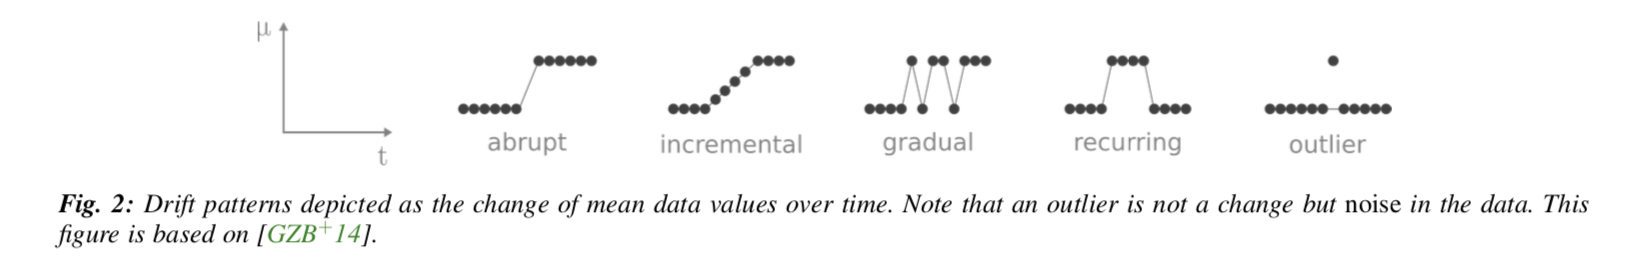

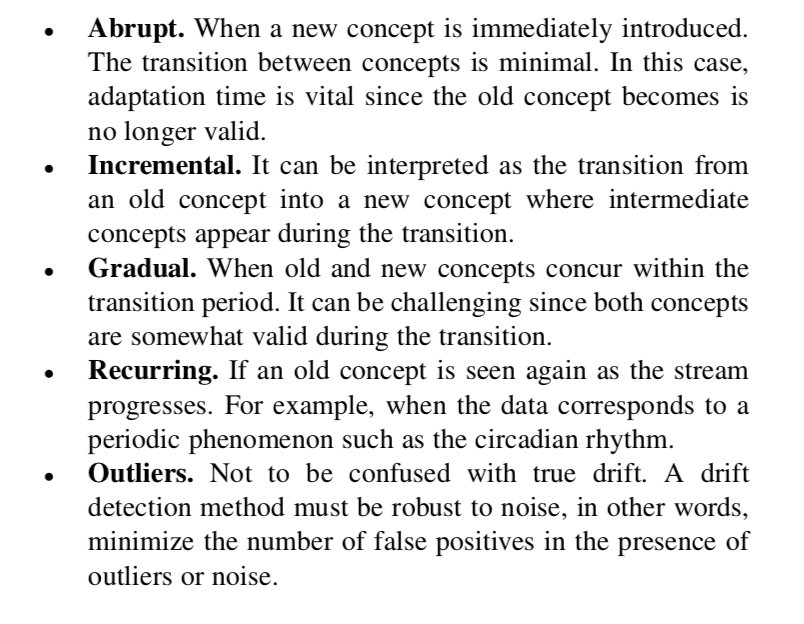

### Drift detection test

In this example we will use the ADaptive WINdowing (`ADWIN`) drift detection method.

The goal is to detect that drift has occurred, after samples **1000** and **2000** in the synthetic data stream.

In [ ]:
# Instantiate the ADWIN drift detector
drift_detector = ADWIN()

for i, val in enumerate(stream):
    drift_detector.add_element(val)        # Data is processed one sample at a time
    if drift_detector.detected_change():
        print('Change detected at index {}'.format(i))
        drift_detector.reset()

Change detected at index 1055
Change detected at index 2079


Adwin
https://www.cs.upc.edu/~abifet/Prova/

---

# **Exercise 3**

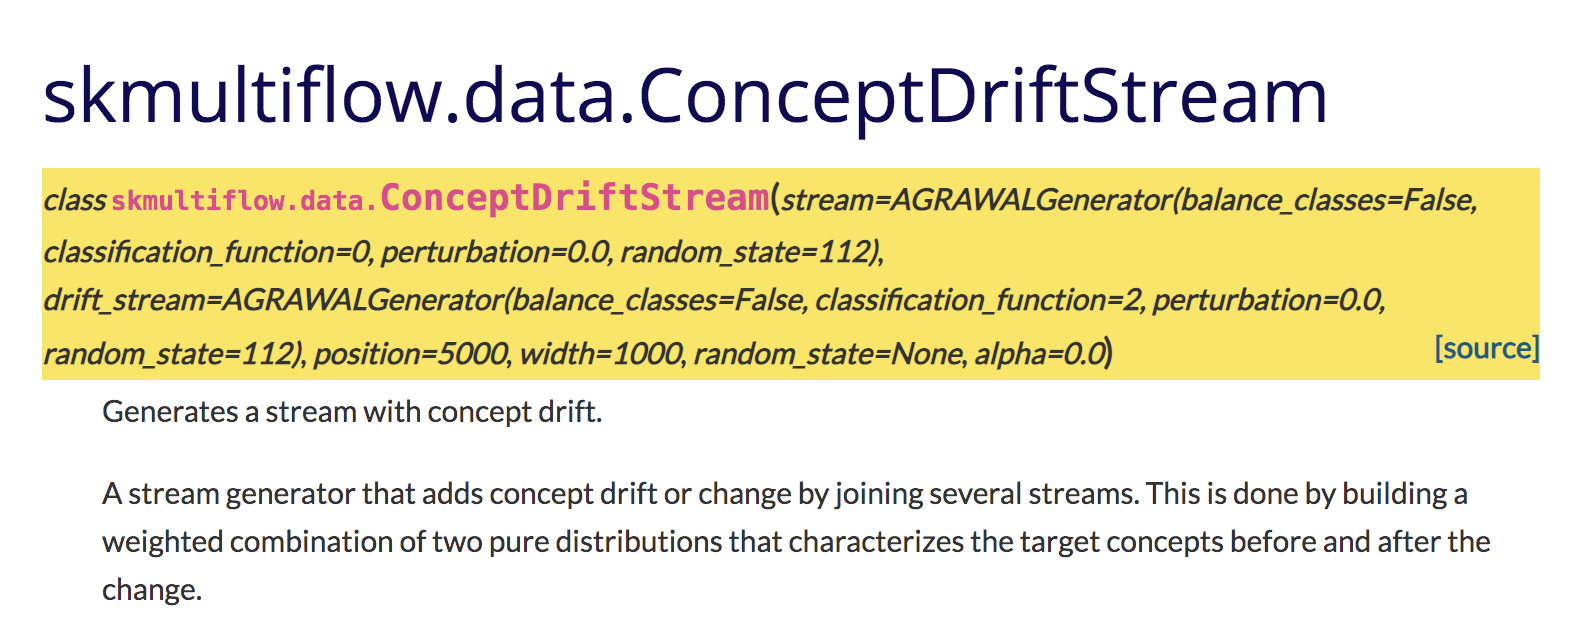

3.1 Use **ConceptDriftStream** with the models in Exercise 2.1 and compare the results with that of Exercise 2.1.

---

### Impact on predictive performance

In this example we will use two popular stream models:

1. The `Hoeffding Tree` is a type of decision tree designed for data streams.
2. The `Hoeffding Adaptive Tree` is an improvement over the original `Hoeffding Tree`.

The `Hoeffding Adaptive Tree` uses `ADWIN` to detect changes, if a change is detected at a given branch, an alternate branch is created and eventually replaces the original branch if it shows better performance on new data.

For this example we will load the data from a csv file using the `FileStream` class.

The data corresponds to the output of the `AGRAWALGenerator` with 3 **gradual drifts** at the 5k, 10k and 15k marks.

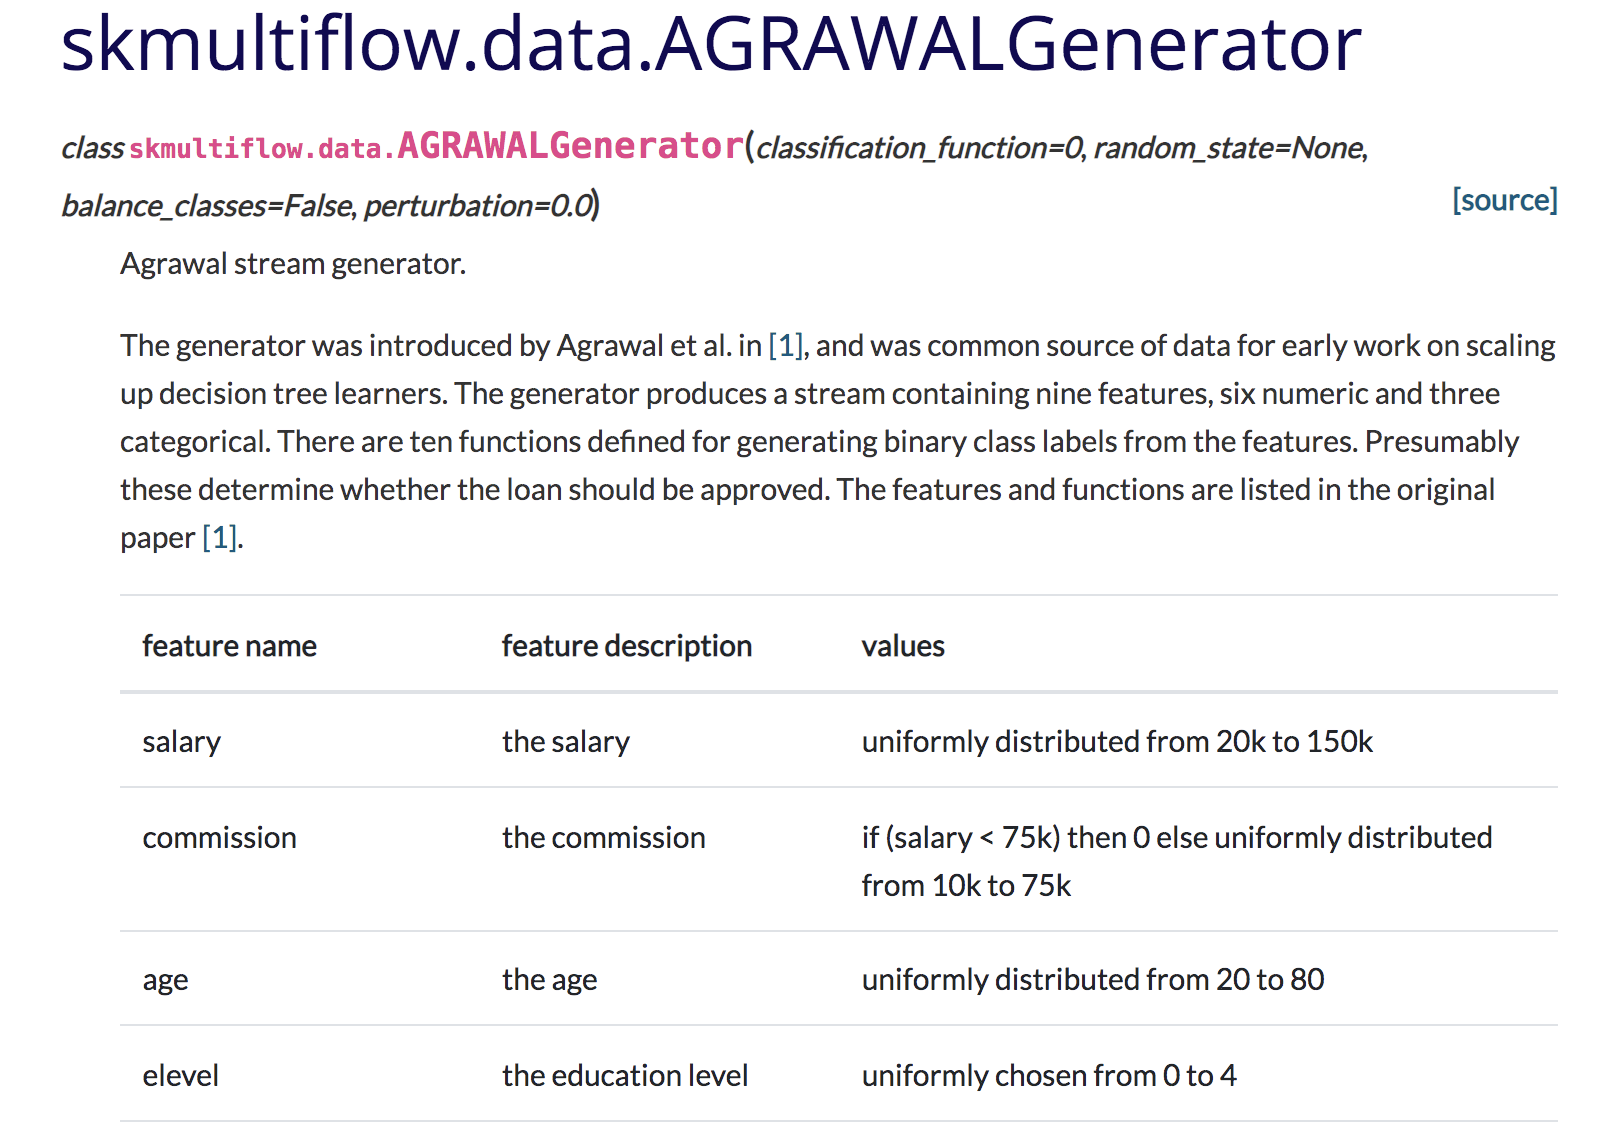

 ## What is hoeffding tree 

The Hoeffding tree is an incremental decision tree learner for large data streams, 
that assumes that the data distribution is not changing over time. 
It grows incrementally a decision tree based on ***the theoretical guaranteesof the Hoeffding bound (or additive Chernoff bound).***

A node is expanded as soon as there is sufficient statistical evidence that an optimal splitting feature exists, 
a decision based on the distribution-independent Hoeffding bound. 
The model learned by the Hoeffding tree is asymptotically nearly identical to the one built by 
a non-incremental learner, if the number of training instances is large enough


P. Domingos and G. Hulten. Mining High-Speed Data Streams. In KDD, pages 71-80, Boston, MA, 2000. ACM Press.

G. Hulten, L. Spencer, and P. Domingos. Mining time-changing data streams. In KDD, pages 97–106, San Francisco, CA, 2001. ACM Press.
       

In [ ]:
# Load data
stream = FileStream("https://raw.githubusercontent.com/ekaratnida/Data_Streaming_and_Realtime_Analytics/main/Week09/multiflow/agr_a_20k.csv")
# Setup estimators
cfiers = [HoeffdingTreeClassifier(), HoeffdingAdaptiveTreeClassifier()]
# Setup evaluations
eval = EvaluatePrequential(show_plot=True,
                           metrics=['accuracy', 'kappa', 'model_size'],
                           n_wait=100)

Run the evaluation

In [ ]:
eval.evaluate(stream=stream, model=cfiers, model_names=['HT', 'HAT']);

<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [28.83s]
Processed samples: 20000
Mean performance:
HT - Accuracy     : 0.7279
HT - Kappa        : 0.4530
HT - Size (kB)          : 175.8711
HAT - Accuracy     : 0.7727
HAT - Kappa        : 0.5429
HAT - Size (kB)          : 122.0947


## **Exercise 4**

4.1 Compare the results with traditional decision tree
